In [1]:
import os
import json
import pickle
import numpy as np
from matplotlib import pyplot as plt

In [2]:
for config_file in [
    f for f in os.listdir(os.path.join('..', 'config')) if f.split('.')[-1] == 'json'
]:
    with open(os.path.join('..', 'config', config_file), 'r') as f:
        settings = json.load(f)
    print(f'Successfully opened {os.path.join("..", "config", config_file)}')

Successfully opened ../config/SyntheticAES__num_leaking_points_sweep.json
Successfully opened ../config/SyntheticAES__trace_length_sweep.json
Successfully opened ../config/SyntheticAES__initial_trial.json
Successfully opened ../config/SyntheticAES__dataset_size_sweep.json
Successfully opened ../config/SyntheticAES__default.json
Successfully opened ../config/SyntheticAES__delay_sweep.json
Successfully opened ../config/SyntheticAES__noise_sweep.json


# Noise sweep

In [3]:
exp_name = 'SyntheticAES__noise_sweep'
with open(os.path.join('..', 'config', f'{exp_name}.json'), 'r') as f:
    exp_settings = json.load(f)
noise_vals = exp_settings['sweep_vals']['dataset_kwargs']['hamming_weight_variance_props']
seed_vals = exp_settings['sweep_vals']['seed']

save_dir = exp_settings['save_dir']
trial_dirs = [
    dirname for dirname in os.listdir(os.path.join('..', 'results', save_dir))
    if os.path.isdir(os.path.join('..', 'results', save_dir, dirname))
]

results = {
    method_name: {
        'mean_ratios': np.empty((len(seed_vals), len(noise_vals)), dtype=float),
        'extrema_ratios': np.empty((len(seed_vals), len(noise_vals)))
    } for method_name in (
        'adversarial_training', 'train_saliency_map', 'val_saliency_map', 'signal_noise_ratio', 'sum_of_differences'
    )
}

for trial_dir in trial_dirs:
    trial_base = os.path.join('..', 'results', save_dir, trial_dir)
    with open(os.path.join(trial_base, 'settings.json'), 'r') as f:
        trial_settings = json.load(f)
    if ('ref_vals' in trial_settings['dataset_kwargs']) and (trial_settings['dataset_kwargs']['ref_vals']) != 0:
        continue
    noise_val = trial_settings['dataset_kwargs']['hamming_weight_variance_props']
    seed_val = trial_settings['seed']
    for method_name in results.keys():
        if method_name in ('train_saliency_map', 'val_saliency_map'):
            with open(os.path.join(trial_base, 'results', 'saliency_map.pickle'), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, noise_vals.index(noise_val)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, noise_vals.index(noise_val)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_extrema_ratio']
        else:
            with open(os.path.join(trial_base, 'results', '.'.join((method_name, 'pickle'))), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, noise_vals.index(noise_val)] = method_results['mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, noise_vals.index(noise_val)] = method_results['mask_ratios']['mask_extrema_ratio']

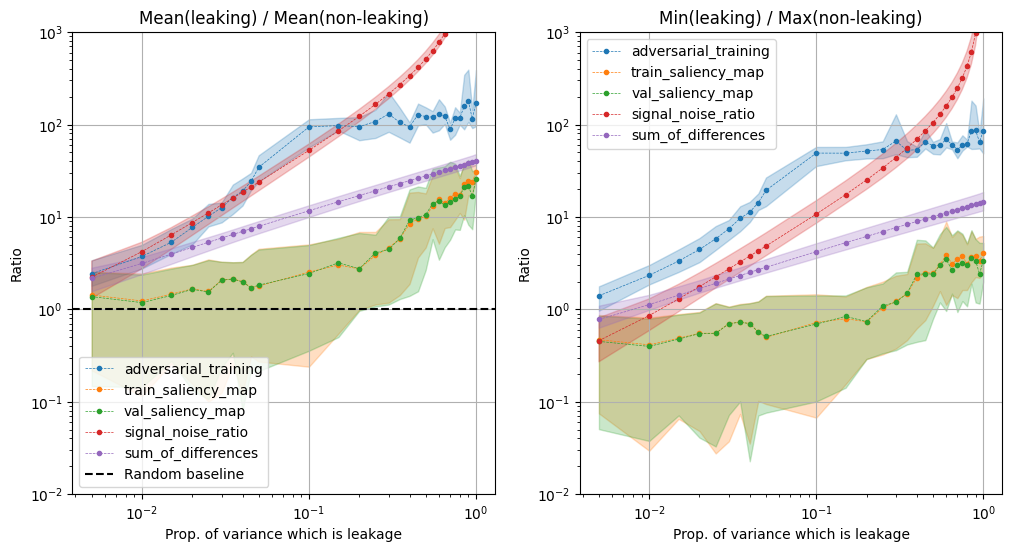

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for method_name in results.keys():
    xvals = noise_vals #np.arange(len(noise_vals))
    p = axes[0].plot(xvals, np.mean(results[method_name]['mean_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name)
    color = p[0].get_color()
    axes[0].fill_between(xvals, np.min(results[method_name]['mean_ratios'], axis=0), np.max(results[method_name]['mean_ratios'], axis=0), alpha=0.25, color=color)
    axes[1].plot(xvals, np.mean(results[method_name]['extrema_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name, color=color)
    axes[1].fill_between(xvals, np.min(results[method_name]['extrema_ratios'], axis=0), np.max(results[method_name]['extrema_ratios'], axis=0), alpha=0.25, color=color)
    axes[0].set_title('Mean(leaking) / Mean(non-leaking)')
    axes[1].set_title('Min(leaking) / Max(non-leaking)')
axes[0].axhline(1e0, label='Random baseline', color='black', linestyle='--')
    
for ax in axes.flatten():
    ax.set_xlabel('Prop. of variance which is leakage')
    ax.set_ylabel('Ratio')
    ax.grid(True)
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1e3)
    #ax.set_xticks(ticks=xvals, labels=noise_vals)

# Maximum delay sweep

In [5]:
exp_name = 'SyntheticAES__delay_sweep'
with open(os.path.join('..', 'config', f'{exp_name}.json'), 'r') as f:
    exp_settings = json.load(f)
delay_vals = exp_settings['sweep_vals']['dataset_kwargs']['maximum_delay']
seed_vals = exp_settings['sweep_vals']['seed']

save_dir = exp_settings['save_dir']
trial_dirs = [
    dirname for dirname in os.listdir(os.path.join('..', 'results', save_dir))
    if os.path.isdir(os.path.join('..', 'results', save_dir, dirname))
]

results = {
    method_name: {
        'mean_ratios': np.empty((len(seed_vals), len(delay_vals)), dtype=float),
        'extrema_ratios': np.empty((len(seed_vals), len(delay_vals)))
    } for method_name in (
        'adversarial_training', 'train_saliency_map', 'val_saliency_map', 'signal_noise_ratio', 'sum_of_differences'
    )
}

for trial_dir in trial_dirs:
    trial_base = os.path.join('..', 'results', save_dir, trial_dir)
    with open(os.path.join(trial_base, 'settings.json'), 'r') as f:
        trial_settings = json.load(f)
    if ('ref_vals' in trial_settings['dataset_kwargs']) and (trial_settings['dataset_kwargs']['ref_vals']) != 0:
        continue
    delay_val = trial_settings['dataset_kwargs']['maximum_delay']
    seed_val = trial_settings['seed']
    for method_name in results.keys():
        if method_name in ('train_saliency_map', 'val_saliency_map'):
            with open(os.path.join(trial_base, 'results', 'saliency_map.pickle'), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, delay_vals.index(delay_val)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, delay_vals.index(delay_val)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_extrema_ratio']
        else:
            with open(os.path.join(trial_base, 'results', '.'.join((method_name, 'pickle'))), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, delay_vals.index(delay_val)] = method_results['mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, delay_vals.index(delay_val)] = method_results['mask_ratios']['mask_extrema_ratio']

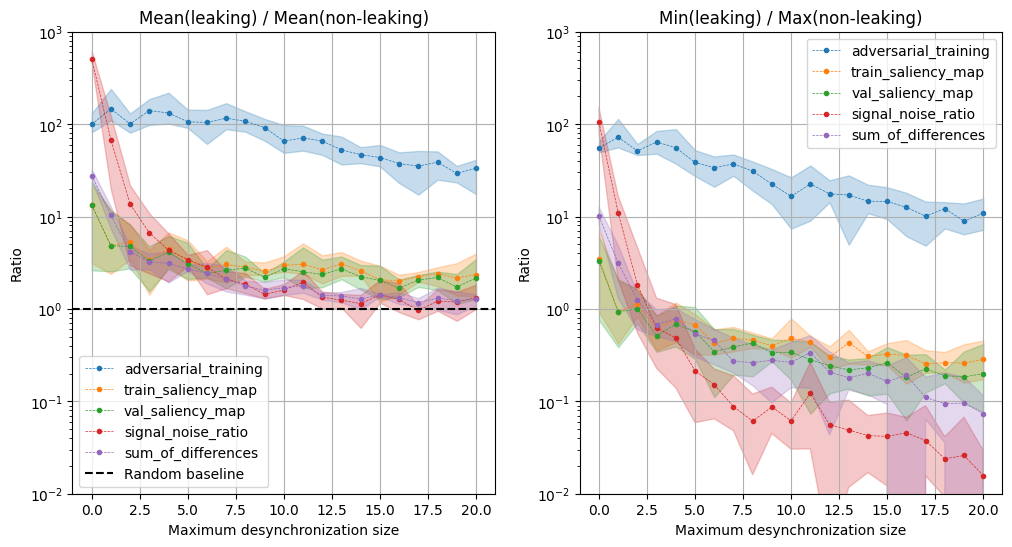

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for method_name in results.keys():
    xvals = delay_vals
    p = axes[0].plot(xvals, np.mean(results[method_name]['mean_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name)
    color = p[0].get_color()
    axes[0].fill_between(xvals, np.min(results[method_name]['mean_ratios'], axis=0), np.max(results[method_name]['mean_ratios'], axis=0), alpha=0.25, color=color)
    axes[1].plot(xvals, np.mean(results[method_name]['extrema_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name, color=color)
    axes[1].fill_between(xvals, np.min(results[method_name]['extrema_ratios'], axis=0), np.max(results[method_name]['extrema_ratios'], axis=0), alpha=0.25, color=color)
    axes[0].set_title('Mean(leaking) / Mean(non-leaking)')
    axes[1].set_title('Min(leaking) / Max(non-leaking)')
axes[0].axhline(1e0, label='Random baseline', color='black', linestyle='--')
    
for ax in axes.flatten():
    ax.set_xlabel('Maximum desynchronization size')
    ax.set_ylabel('Ratio')
    ax.grid(True)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1e3)
    #ax.set_xscale('symlog', linthresh=1e-1)
    #ax.set_xlim(0, max(delay_vals))
    #ax.set_xticks(ticks=xvals, labels=delay_vals)

# Dataset size sweep

In [7]:
exp_name = 'SyntheticAES__dataset_size_sweep'
with open(os.path.join('..', 'config', f'{exp_name}.json'), 'r') as f:
    exp_settings = json.load(f)
dataset_sizes = exp_settings['sweep_vals']['dataset_kwargs']['num_traces']
seed_vals = exp_settings['sweep_vals']['seed']

save_dir = exp_settings['save_dir']
trial_dirs = [
    dirname for dirname in os.listdir(os.path.join('..', 'results', save_dir))
    if os.path.isdir(os.path.join('..', 'results', save_dir, dirname))
]

results = {
    method_name: {
        'mean_ratios': np.empty((len(seed_vals), len(dataset_sizes)), dtype=float),
        'extrema_ratios': np.empty((len(seed_vals), len(dataset_sizes)))
    } for method_name in (
        'adversarial_training', 'train_saliency_map', 'val_saliency_map', 'signal_noise_ratio', 'sum_of_differences'
    )
}

for trial_dir in trial_dirs:
    trial_base = os.path.join('..', 'results', save_dir, trial_dir)
    with open(os.path.join(trial_base, 'settings.json'), 'r') as f:
        trial_settings = json.load(f)
    if ('ref_vals' in trial_settings['dataset_kwargs']) and (trial_settings['dataset_kwargs']['ref_vals']) != 0:
        continue
    dataset_size = trial_settings['dataset_kwargs']['num_traces']
    seed_val = trial_settings['seed']
    for method_name in results.keys():
        if method_name in ('train_saliency_map', 'val_saliency_map'):
            with open(os.path.join(trial_base, 'results', 'saliency_map.pickle'), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, dataset_sizes.index(dataset_size)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, dataset_sizes.index(dataset_size)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_extrema_ratio']
        else:
            with open(os.path.join(trial_base, 'results', '.'.join((method_name, 'pickle'))), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, dataset_sizes.index(dataset_size)] = method_results['mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, dataset_sizes.index(dataset_size)] = method_results['mask_ratios']['mask_extrema_ratio']

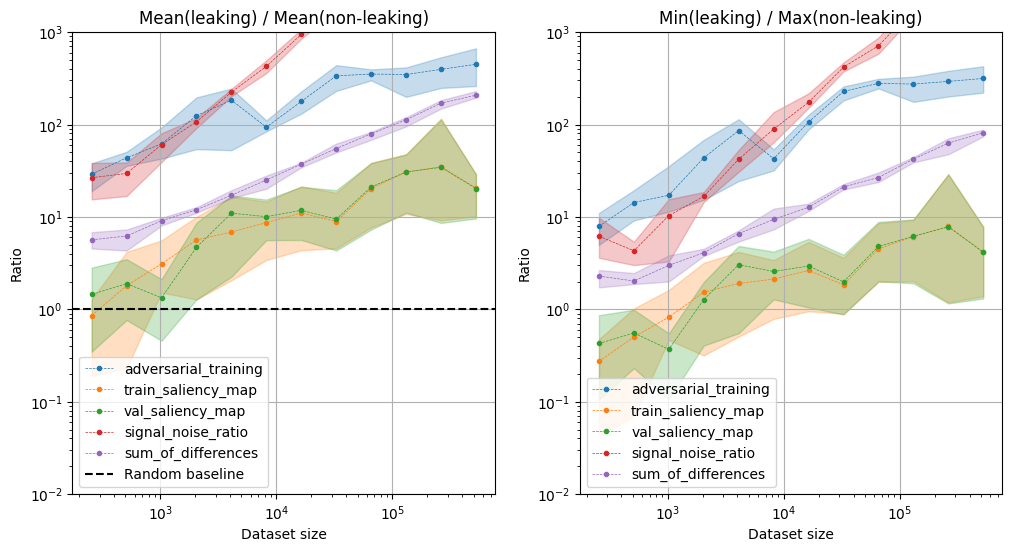

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for method_name in results.keys():
    xvals = dataset_sizes #np.arange(len(noise_vals))
    p = axes[0].plot(xvals, np.mean(results[method_name]['mean_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name)
    color = p[0].get_color()
    axes[0].fill_between(xvals, np.min(results[method_name]['mean_ratios'], axis=0), np.max(results[method_name]['mean_ratios'], axis=0), alpha=0.25, color=color)
    axes[1].plot(xvals, np.mean(results[method_name]['extrema_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name, color=color)
    axes[1].fill_between(xvals, np.min(results[method_name]['extrema_ratios'], axis=0), np.max(results[method_name]['extrema_ratios'], axis=0), alpha=0.25, color=color)
    axes[0].set_title('Mean(leaking) / Mean(non-leaking)')
    axes[1].set_title('Min(leaking) / Max(non-leaking)')
axes[0].axhline(1e0, label='Random baseline', color='black', linestyle='--')
    
for ax in axes.flatten():
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('Ratio')
    ax.grid(True)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1e3)
    ax.set_xscale('log')
    #ax.set_xticks(ticks=xvals, labels=noise_vals)

# Number of leaking points sweep

In [9]:
exp_name = 'SyntheticAES__num_leaking_points_sweep'
with open(os.path.join('..', 'config', f'{exp_name}.json'), 'r') as f:
    exp_settings = json.load(f)
leaking_point_counts = exp_settings['sweep_vals']['dataset_kwargs']['leaking_measurements_1o']
seed_vals = exp_settings['sweep_vals']['seed']

save_dir = exp_settings['save_dir']
trial_dirs = [
    dirname for dirname in os.listdir(os.path.join('..', 'results', save_dir))
    if os.path.isdir(os.path.join('..', 'results', save_dir, dirname))
]

results = {
    method_name: {
        'mean_ratios': np.empty((len(seed_vals), len(leaking_point_counts)), dtype=float),
        'extrema_ratios': np.empty((len(seed_vals), len(leaking_point_counts)))
    } for method_name in (
        'adversarial_training', 'train_saliency_map', 'val_saliency_map', 'signal_noise_ratio', 'sum_of_differences'
    )
}

for trial_dir in trial_dirs:
    trial_base = os.path.join('..', 'results', save_dir, trial_dir)
    with open(os.path.join(trial_base, 'settings.json'), 'r') as f:
        trial_settings = json.load(f)
    if ('ref_vals' in trial_settings['dataset_kwargs']) and (trial_settings['dataset_kwargs']['ref_vals']) != 0:
        continue
    leaking_point_count = trial_settings['dataset_kwargs']['leaking_measurements_1o']
    if not leaking_point_count in leaking_point_counts:
        continue
    seed_val = trial_settings['seed']
    for method_name in results.keys():
        if method_name in ('train_saliency_map', 'val_saliency_map'):
            with open(os.path.join(trial_base, 'results', 'saliency_map.pickle'), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, leaking_point_counts.index(leaking_point_count)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, leaking_point_counts.index(leaking_point_count)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_extrema_ratio']
        else:
            with open(os.path.join(trial_base, 'results', '.'.join((method_name, 'pickle'))), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, leaking_point_counts.index(leaking_point_count)] = method_results['mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, leaking_point_counts.index(leaking_point_count)] = method_results['mask_ratios']['mask_extrema_ratio']

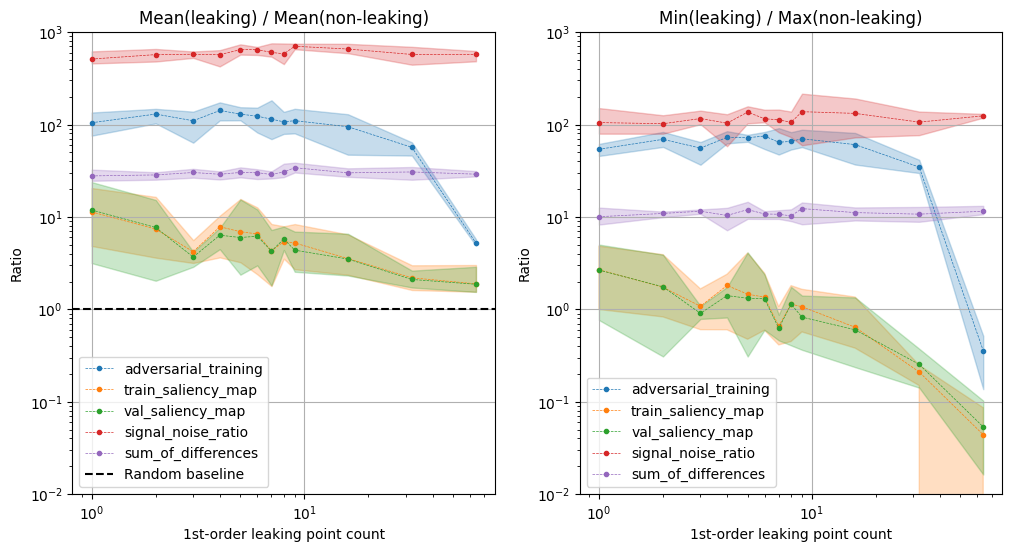

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for method_name in results.keys():
    xvals = leaking_point_counts #np.arange(len(noise_vals))
    p = axes[0].plot(xvals, np.mean(results[method_name]['mean_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name)
    color = p[0].get_color()
    axes[0].fill_between(xvals, np.min(results[method_name]['mean_ratios'], axis=0), np.max(results[method_name]['mean_ratios'], axis=0), alpha=0.25, color=color)
    axes[1].plot(xvals, np.mean(results[method_name]['extrema_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name, color=color)
    axes[1].fill_between(xvals, np.min(results[method_name]['extrema_ratios'], axis=0), np.max(results[method_name]['extrema_ratios'], axis=0), alpha=0.25, color=color)
    axes[0].set_title('Mean(leaking) / Mean(non-leaking)')
    axes[1].set_title('Min(leaking) / Max(non-leaking)')
axes[0].axhline(1e0, label='Random baseline', color='black', linestyle='--')
    
for ax in axes.flatten():
    ax.set_xlabel('1st-order leaking point count')
    ax.set_ylabel('Ratio')
    ax.grid(True)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-2, 1e3)

# Trace length sweep

In [11]:
exp_name = 'SyntheticAES__trace_length_sweep'
with open(os.path.join('..', 'config', f'{exp_name}.json'), 'r') as f:
    exp_settings = json.load(f)
trace_lengths = exp_settings['sweep_vals']['dataset_kwargs']['measurements_per_trace']
seed_vals = exp_settings['sweep_vals']['seed']

save_dir = exp_settings['save_dir']
trial_dirs = [
    dirname for dirname in os.listdir(os.path.join('..', 'results', save_dir))
    if os.path.isdir(os.path.join('..', 'results', save_dir, dirname))
]

results = {
    method_name: {
        'mean_ratios': np.empty((len(seed_vals), len(trace_lengths)), dtype=float),
        'extrema_ratios': np.empty((len(seed_vals), len(trace_lengths)))
    } for method_name in (
        'adversarial_training', 'train_saliency_map', 'val_saliency_map', 'signal_noise_ratio', 'sum_of_differences'
    )
}

for trial_dir in trial_dirs:
    trial_base = os.path.join('..', 'results', save_dir, trial_dir)
    with open(os.path.join(trial_base, 'settings.json'), 'r') as f:
        trial_settings = json.load(f)
    if ('ref_vals' in trial_settings['dataset_kwargs']) and (trial_settings['dataset_kwargs']['ref_vals']) != 0:
        continue
    trace_length = trial_settings['dataset_kwargs']['measurements_per_trace']
    if not trace_length in trace_lengths:
        continue
    seed_val = trial_settings['seed']
    for method_name in results.keys():
        if method_name in ('train_saliency_map', 'val_saliency_map'):
            with open(os.path.join(trial_base, 'results', 'saliency_map.pickle'), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, trace_lengths.index(trace_length)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, trace_lengths.index(trace_length)] = method_results[method_name.split('_')[0]+'_mask_ratios']['mask_extrema_ratio']
        else:
            with open(os.path.join(trial_base, 'results', '.'.join((method_name, 'pickle'))), 'rb') as f:
                method_results = pickle.load(f)
            results[method_name]['mean_ratios'][seed_val, trace_lengths.index(trace_length)] = method_results['mask_ratios']['mask_mean_ratio']
            results[method_name]['extrema_ratios'][seed_val, trace_lengths.index(trace_length)] = method_results['mask_ratios']['mask_extrema_ratio']

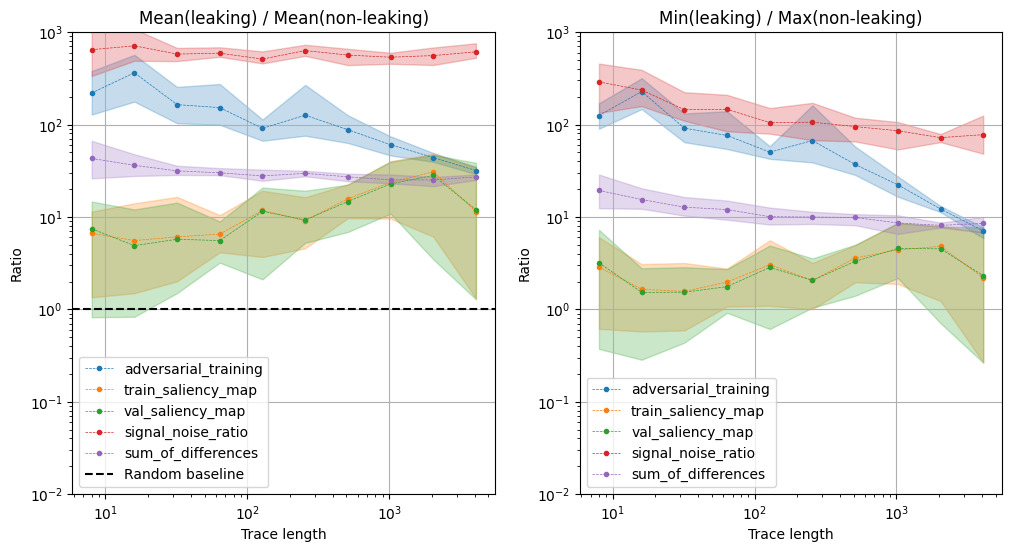

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for method_name in results.keys():
    xvals = trace_lengths #np.arange(len(noise_vals))
    p = axes[0].plot(xvals, np.mean(results[method_name]['mean_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name)
    color = p[0].get_color()
    axes[0].fill_between(xvals, np.min(results[method_name]['mean_ratios'], axis=0), np.max(results[method_name]['mean_ratios'], axis=0), alpha=0.25, color=color)
    axes[1].plot(xvals, np.mean(results[method_name]['extrema_ratios'], axis=0), linestyle='--', linewidth=0.5, marker='.', label=method_name, color=color)
    axes[1].fill_between(xvals, np.min(results[method_name]['extrema_ratios'], axis=0), np.max(results[method_name]['extrema_ratios'], axis=0), alpha=0.25, color=color)
    axes[0].set_title('Mean(leaking) / Mean(non-leaking)')
    axes[1].set_title('Min(leaking) / Max(non-leaking)')
axes[0].axhline(1e0, label='Random baseline', color='black', linestyle='--')
    
for ax in axes.flatten():
    ax.set_xlabel('Trace length')
    ax.set_ylabel('Ratio')
    ax.grid(True)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1e-2, 1e3)